In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Loading Dataset

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

68608000/68606236 [==============================] - 0s 0us/step


In [4]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [6]:
train_dataset

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

In [7]:
validation_dataset

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

## Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)
(1, 160, 160, 3)


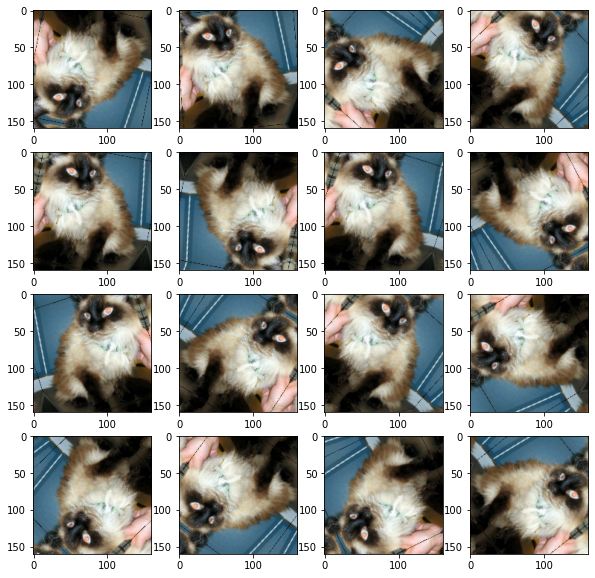

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]   #first image of any random batch
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    print(augmented_image.shape)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

## Model Training

In [11]:
mobilenet = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
for layer in mobilenet.layers:
  layer.trainable = False

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = mobilenet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
________________________________________

In [21]:
model.fit(train_dataset,
                    epochs=10,
          validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 6s 100ms/step - loss: 0.2883 - accuracy: 0.8735 - val_loss: 0.1174 - val_accuracy: 0.9540
Epoch 2/10
63/63 [==============================] - 6s 94ms/step - loss: 0.2471 - accuracy: 0.8945 - val_loss: 0.1008 - val_accuracy: 0.9610
Epoch 3/10
63/63 [==============================] - 6s 95ms/step - loss: 0.2492 - accuracy: 0.8840 - val_loss: 0.0922 - val_accuracy: 0.9670
Epoch 4/10
63/63 [==============================] - 6s 94ms/step - loss: 0.2220 - accuracy: 0.9005 - val_loss: 0.0856 - val_accuracy: 0.9720
Epoch 5/10
63/63 [==============================] - 6s 96ms/step - loss: 0.2038 - accuracy: 0.9055 - val_loss: 0.0790 - val_accuracy: 0.9700
Epoch 6/10
63/63 [==============================] - 6s 95ms/step - loss: 0.2012 - accuracy: 0.9125 - val_loss: 0.0761 - val_accuracy: 0.9760
Epoch 7/10
63/63 [==============================] - 6s 94ms/step - loss: 0.1964 - accuracy: 0.9200 - val_loss: 0.0769 - val_accuracy: 0.9750
Epoch 8/10
6

## Testing and Prediction


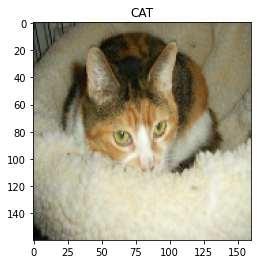

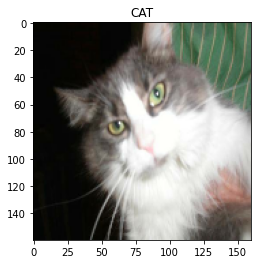

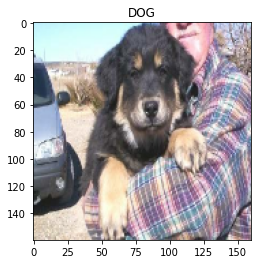

In [29]:

class_names=['CAT','DOG']
for images, labels in test_dataset.take(1):
  for i in range(3):
    img=(images[i].numpy().astype("uint8"))
    plt.imshow(img)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 
    predictions = model.predict(img_array).flatten()
    score = tf.nn.sigmoid(predictions[0])
    score = tf.where(score < 0.5, 0, 1)
    plt.title(class_names[score])
    plt.show()
